In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

In [ ]:
# Define paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/New/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/New/train'

# ImageDataGenerator for loading and augmenting data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)  # Using 20% of the data for validation

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 2040 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [ ]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
from tensorflow.keras.optimizers import Adam
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14978370 (57.14 MB)
Trainable params: 263682 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10)

Epoch 1/10
63/63 [==============================] - 43s 353ms/step - loss: 0.6159 - accuracy: 0.6609 - val_loss: 0.4551 - val_accuracy: 0.8040
Epoch 2/10
63/63 [==============================] - 18s 280ms/step - loss: 0.4353 - accuracy: 0.8038 - val_loss: 0.3777 - val_accuracy: 0.8466
Epoch 3/10
63/63 [==============================] - 21s 338ms/step - loss: 0.3540 - accuracy: 0.8431 - val_loss: 0.2909 - val_accuracy: 0.8835
Epoch 4/10
63/63 [==============================] - 20s 321ms/step - loss: 0.2893 - accuracy: 0.8855 - val_loss: 0.2823 - val_accuracy: 0.9091
Epoch 5/10
63/63 [==============================] - 18s 284ms/step - loss: 0.2506 - accuracy: 0.8999 - val_loss: 0.2878 - val_accuracy: 0.9091
Epoch 6/10
63/63 [==============================] - 18s 285ms/step - loss: 0.2118 - accuracy: 0.9283 - val_loss: 0.2613 - val_accuracy: 0.9091
Epoch 7/10
63/63 [==============================] - 19s 293ms/step - loss: 0.1944 - accuracy: 0.9308 - val_loss: 0.2438 - val_accuracy: 0.8977

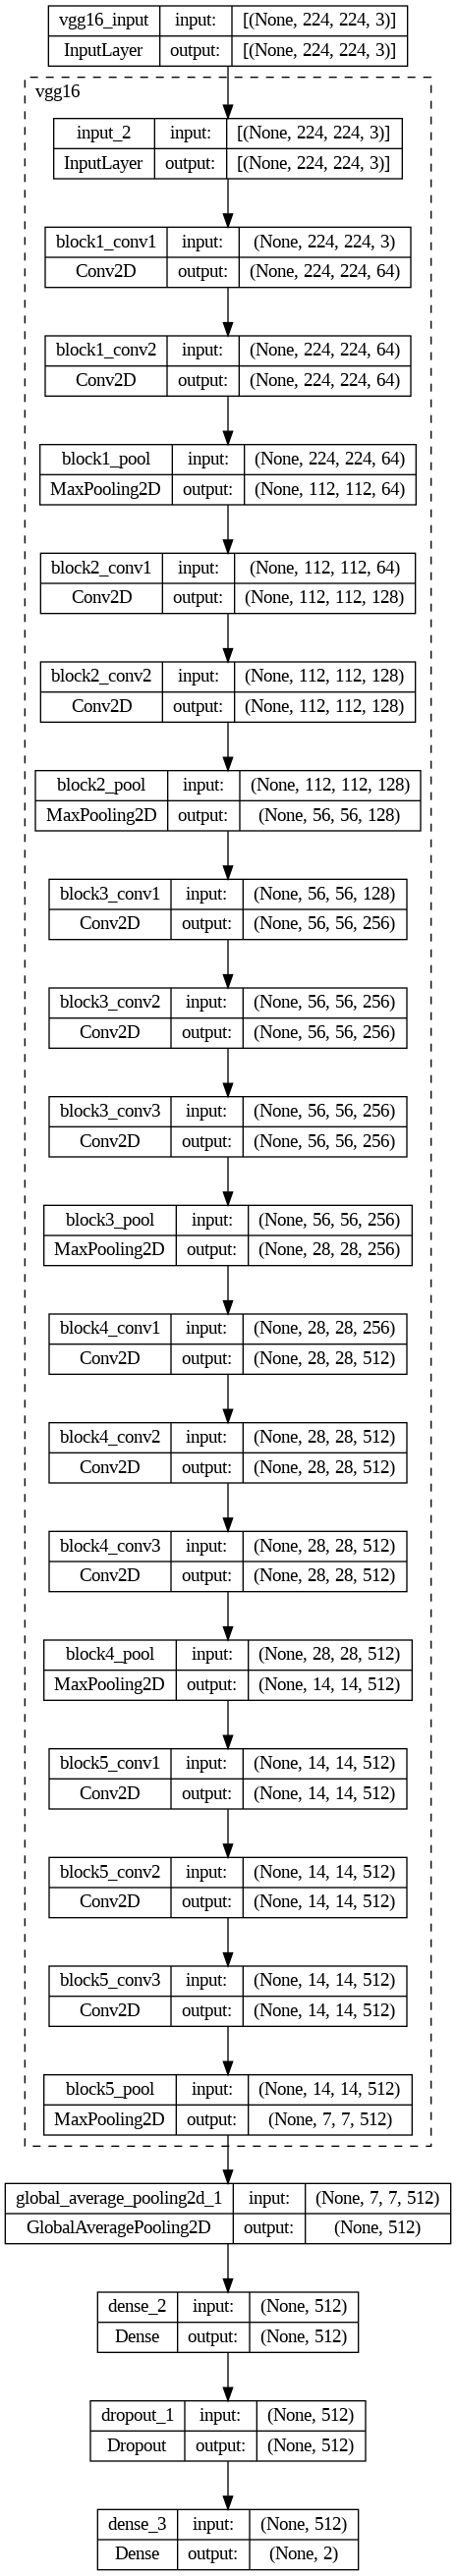

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

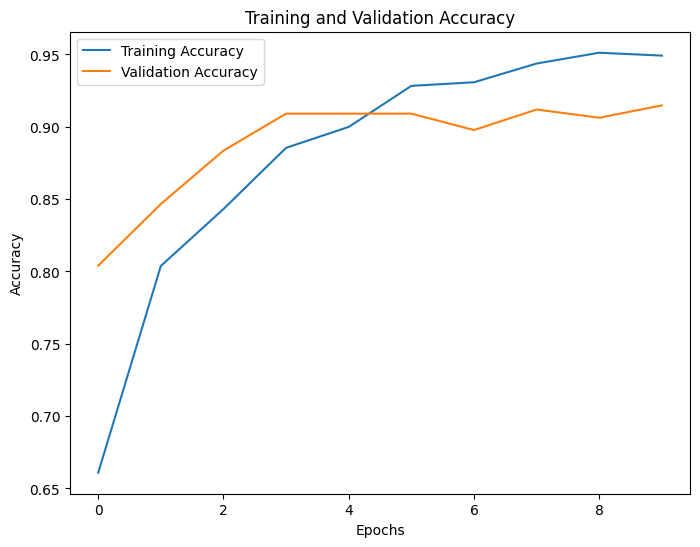

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

75/75 [==============================] - 17s 230ms/step
Accuracy: 0.9629
Precision: 0.9869
Recall: 0.9383
F1-score: 0.9620
Confusion Matrix
[[1185   15]
 [  74 1126]]
Classification Report
              precision    recall  f1-score   support

  NoActivity       0.94      0.99      0.96      1200
 YesActivity       0.99      0.94      0.96      1200

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



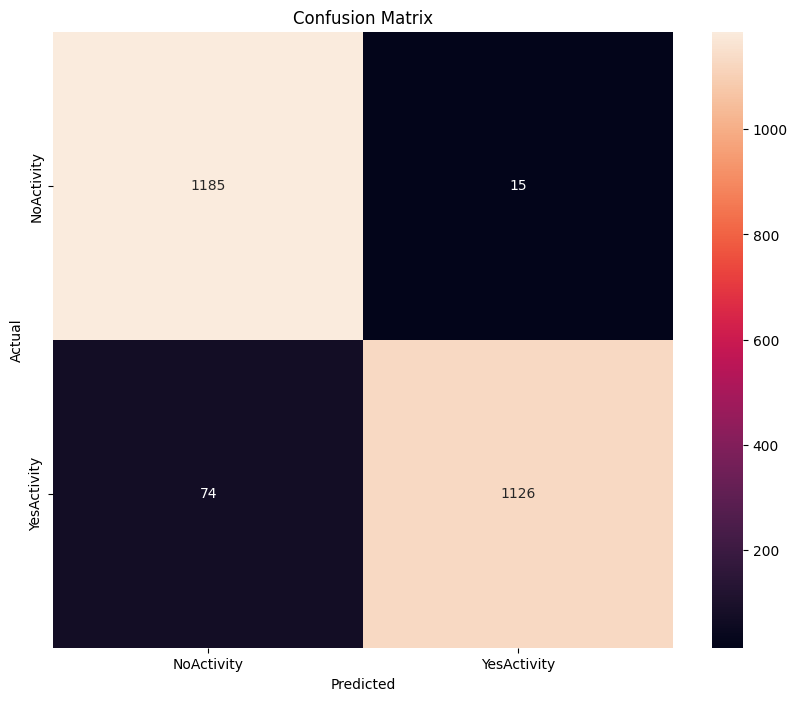

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Evaluate the model
test_generator.reset()
Y_pred = model.predict(test_generator, test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)



accuracy = accuracy_score(test_generator.classes, y_pred)
precision = precision_score(test_generator.classes, y_pred)
recall = recall_score(test_generator.classes, y_pred)
f1 = f1_score(test_generator.classes, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm_plot_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()